In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.image as mpimg
from PIL import Image

In [72]:
pitch_types = ['fastball', 'slider', 'curveball', 'changeup']

In [73]:
df_dict = {}
averages_dict = {}
for typ in pitch_types:
    df_dict[typ] = pd.read_csv(typ + '.csv', index_col = 0)
    averages_dict[typ] = pd.read_csv(typ + '_averages.csv', index_col = 0)

In [74]:
nd_id_df = pd.read_csv('pitcher_id.txt', delimiter = '\t')

In [75]:
get_vars = ['Horz Break', 'Induced Vert Break', 'Rel Height', 'Rel Side', 'Extension', 'Rel Speed']
#this process has already been run
for typ in pitch_types:
    average_df = averages_dict[typ]
    cur_df = df_dict[typ]
    for col in get_vars:
        new_name = str(col) + '_stdv'
        average_df[new_name] = [np.NaN]*average_df.index.size
    for pitcher in average_df.index:
        pitcher_df = cur_df[cur_df['Pitcher Id'] == pitcher]
        for col in get_vars:
            cur_col = str(col) + '_stdv'
            average_df[cur_col][pitcher] = pitcher_df[col].std()
    averages_dict[typ] = average_df

In [76]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtype == float:
            mean = df[feature_name].mean()
            stdv = df[feature_name].std()
            result[feature_name] = (df[feature_name] - mean) / stdv
    return result

In [77]:
def ref_normalize(df, ref, ind, key_vars):
    result = df.copy()
    for feature_name in key_vars:
        if df[feature_name].dtype == float:
            mean = ref[feature_name][ind]
#             stdv = ref[str(feature_name)+'_stdv'][ind]
            result[feature_name] = (df[feature_name] - mean)
    return result

In [78]:
def get_axis(lower, upper, step):
    prelim = np.arange(lower, upper, step)
    axis = []
    for elem in prelim:
        axis.append(round(elem, 2))
    return axis

In [80]:
key_vars= ['Horz Break', 'Induced Vert Break', 'Rel Height', 'Rel Side', 'Extension', 'Rel Speed']
pitch_comps = {}

for pitcher in nd_id_df['Pitcher Id']:
    type_comps = {}
    for key in df_dict.keys():
        pitch_df = df_dict[key]
        averages_df = averages_dict[key]
        
        left_df = pitch_df[pitch_df['Pitcher Id'] == pitcher]
        left_df = left_df[left_df['Batter Side'] == 'Left']
        if left_df.index.size == 0:
            continue
        left_df = normalize(left_df)

        right_df = pitch_df[pitch_df['Pitcher Id'] == pitcher]
        right_df = right_df[right_df['Batter Side'] == 'Right']
        if right_df.index.size == 0:
            continue
        right_df = normalize(right_df)

        left_df.reset_index(inplace = True, drop = True)
        right_df.reset_index(inplace = True, drop = True)
        hand = left_df['Pitcher Throws'][0]

        right_comps = pitch_df[pitch_df['Pitcher Throws'] == hand]
        right_comps = right_comps[right_comps['Batter Side'] == 'Right']
        right_comps = ref_normalize(right_comps, averages_df, pitcher, key_vars)

        left_comps = pitch_df[pitch_df['Pitcher Throws'] == hand]
        left_comps = left_comps[left_comps['Batter Side'] == 'Left']
        left_comps = ref_normalize(left_comps, averages_df, pitcher, key_vars)

        left_comps.reset_index(inplace = True, drop = True)
        right_comps.reset_index(inplace = True, drop = True)

        left_comps['total_var'] = [np.NaN]*left_comps.index.size
        right_comps['total_var'] = [np.NaN]*right_comps.index.size

        key_vars= ['Horz Break', 'Induced Vert Break', 'Rel Height', 'Rel Side', 'Extension', 'Rel Speed']
        for comp in left_comps.index:
            tot = 0
            for var in key_vars:
                tot += abs(left_comps[var][comp])
            left_comps['total_var'][comp] = tot
        for comp in right_comps.index:
            tot = 0
            for var in key_vars:
                tot += abs(right_comps[var][comp])
            right_comps['total_var'][comp] = tot

        right_comps['weight'] = 1/right_comps['total_var']
        left_comps['weight'] = 1/left_comps['total_var']

        type_comps[key] = {'right' : right_comps,
                           'left': left_comps}
    pitch_comps[pitcher] = type_comps

/Users/AngelaBeckham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/AngelaBeckham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
p_id = {}
for ind in nd_id_df.index:
    p_id[nd_id_df['Pitcher Id'][ind]] = nd_id_df['Pitcher'][ind]
    
comps_dict = {}
for ident in nd_id_df['Pitcher Id']:
    comps_dict[p_id[ident]] = pitch_comps[ident]

In [86]:
stats = ['whiff%', 'Exit Speed', 'gb%']
# for pitcher in ['Rao, Alex']:
print("the number of pitchers is", len(list(comps_dict.keys())))
for pitcher in comps_dict.keys():
    print(pitcher)
#     for typ in ['fastball']:
    for typ in comps_dict[pitcher].keys():
        for i in ['left', 'right']:
            cur_df = comps_dict[pitcher][typ][i]
            
            mat_dict = {}
            for var in stats:
                mat_dict[var] = []
            
            for y in np.arange(5.0, 0.0, -step):
                height_df = cur_df[cur_df['Plate Loc Height'] <= y]
                height_df = height_df[height_df['Plate Loc Height'] > y - step]
                    
                row_dict = {}
                for var in stats:
                    row_dict[var] = []
                for x in np.arange(-2.5, 2.5, step):
                    side_df = height_df[height_df['Plate Loc Side'] >= x]
                    side_df = side_df[side_df['Plate Loc Side'] < x + step]
                    numer_dict = {}
                    denom_dict = {}
                    nulls_dict = {}
                    for var in stats:
                        numer_dict[var] = 0
                        denom_dict[var] = 0
                        nulls_dict[var] = side_df[var].notnull()
                    for ind in side_df.index:
                        for var in stats:
                            if nulls_dict[var][ind]:
                                numer_dict[var] += side_df['weight'][ind]*side_df[var][ind]
                                denom_dict[var] += side_df['weight'][ind]
                    for var in stats: 
                        if denom_dict[var] != 0:
                            row_dict[var].append(numer_dict[var]/denom_dict[var])
                        else:
                            row_dict[var].append(0)
                for var in stats: 
                    mat_dict[var].append(row_dict[var])
            for var in stats:
                comps_dict[pitcher][typ][i+'_'+var] = mat_dict[var]
                                    

                
#                 var_mat = []
#                 cur_df = comps_dict[pitcher][typ][i]
#                 step = .1
#                 for y in np.arange(5.0, 0.0, -step):
#                     height_df = cur_df[cur_df['Plate Loc Height'] <= y]
#                     height_df = height_df[height_df['Plate Loc Height'] > y - step]
#                     cur_row = []
#                     for x in np.arange(-2.5, 2.5, step):
#                         side_df = height_df[height_df['Plate Loc Side'] >= x]
#                         side_df = side_df[side_df['Plate Loc Side'] < x + step]
#                         numer = 0
#                         denom = 0
#                         nulls = side_df[var].notnull()
#                         for ind in side_df.index:
#                             if nulls[ind]:
#                                 numer += side_df['weight'][ind]*side_df[var][ind]
#                                 denom += side_df['weight'][ind]
#                         if denom != 0:
#                             cur_row.append(numer/denom)
#                         else:
#                             cur_row.append(0)
#                     var_mat.append(cur_row)
#                 comps_dict[pitcher][typ][i] = mat_dict

the number of pitchers is 20
Bedford, Matthew
Bertrand, John Michael
Brannigan, Jack
Cancellieri, Dominic
Cooper, Sammy
Dennies, Jackson
DiBiase, Brent
Kohlhepp, Tanner
Lynch, Ryan
Megias, Mitch
Mercer, Will
Peacock, Gerry
Rao, Alex
Scafidi, Christian
Sheehan, Tommy
Sheridan, Joe
Simon, Liam
Tenuta, Evan
Tyrell, Aidan
Vail, Tommy


In [85]:
comps_dict['Rao, Alex']['fastball']['left_Exit Speed']

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  56.21374483,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  75.11364747,
  0,
  0,
  0,
  0,
  72.86344684,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [87]:
def get_title(var):
    if var == 'whiff%':
        return "Expected Whiff Rate", "Reds", 0, 0.5, 'whiff'
    elif var == 'Exit Speed':
        return "Expected Exit Velocity", "coolwarm", 60, 90, 'velo'
    elif var == 'gb%':
        return 'Expected Ground Ball Rate', "coolwarm", .15, .75, 'gb'
    else:
        return "", "coolwarm", 0 , 100

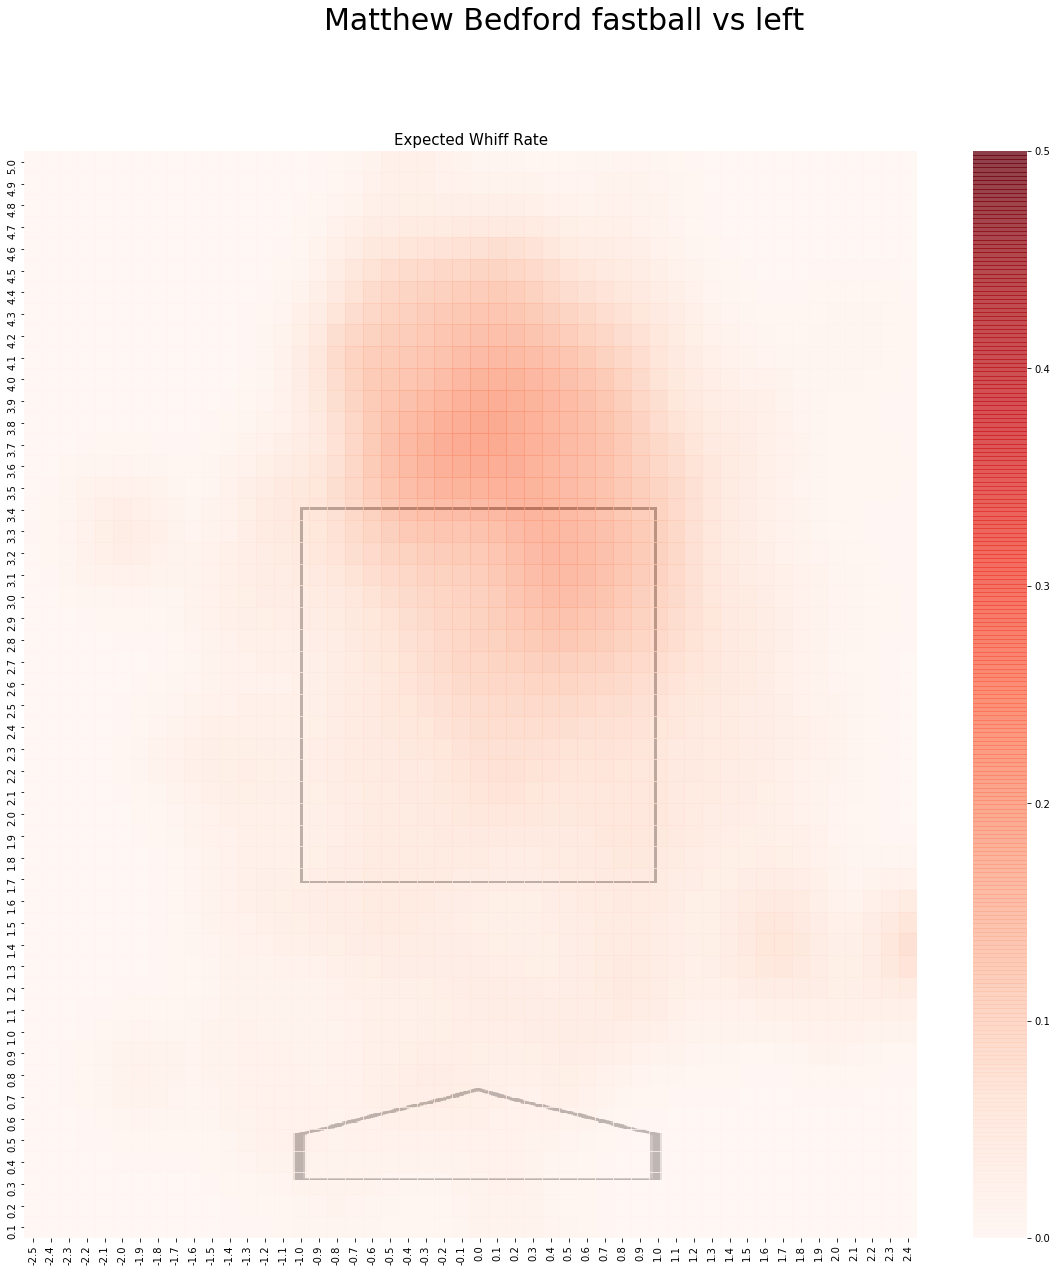

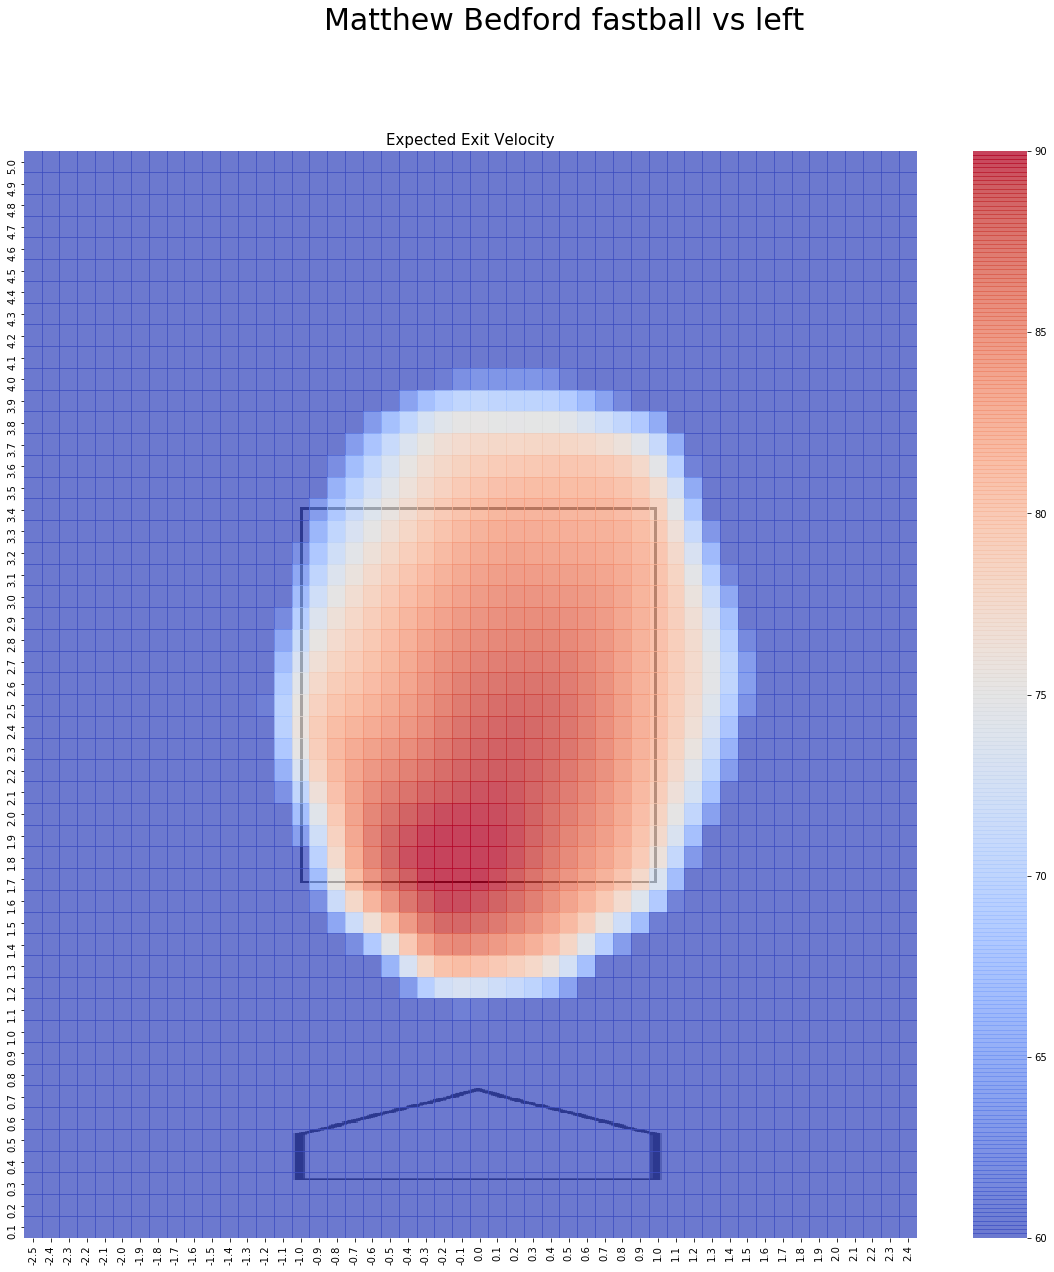

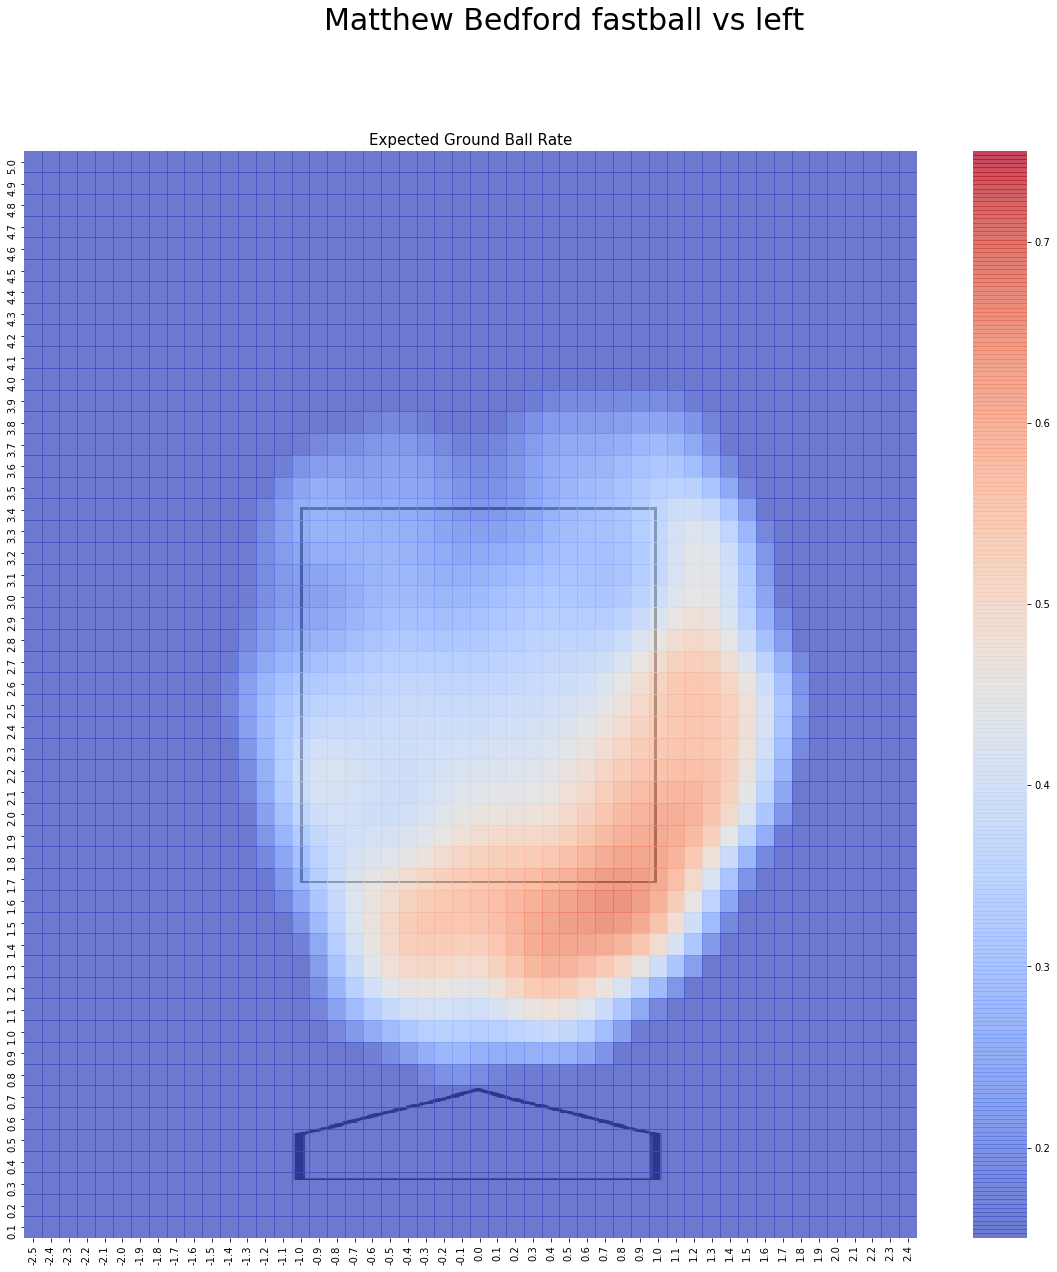

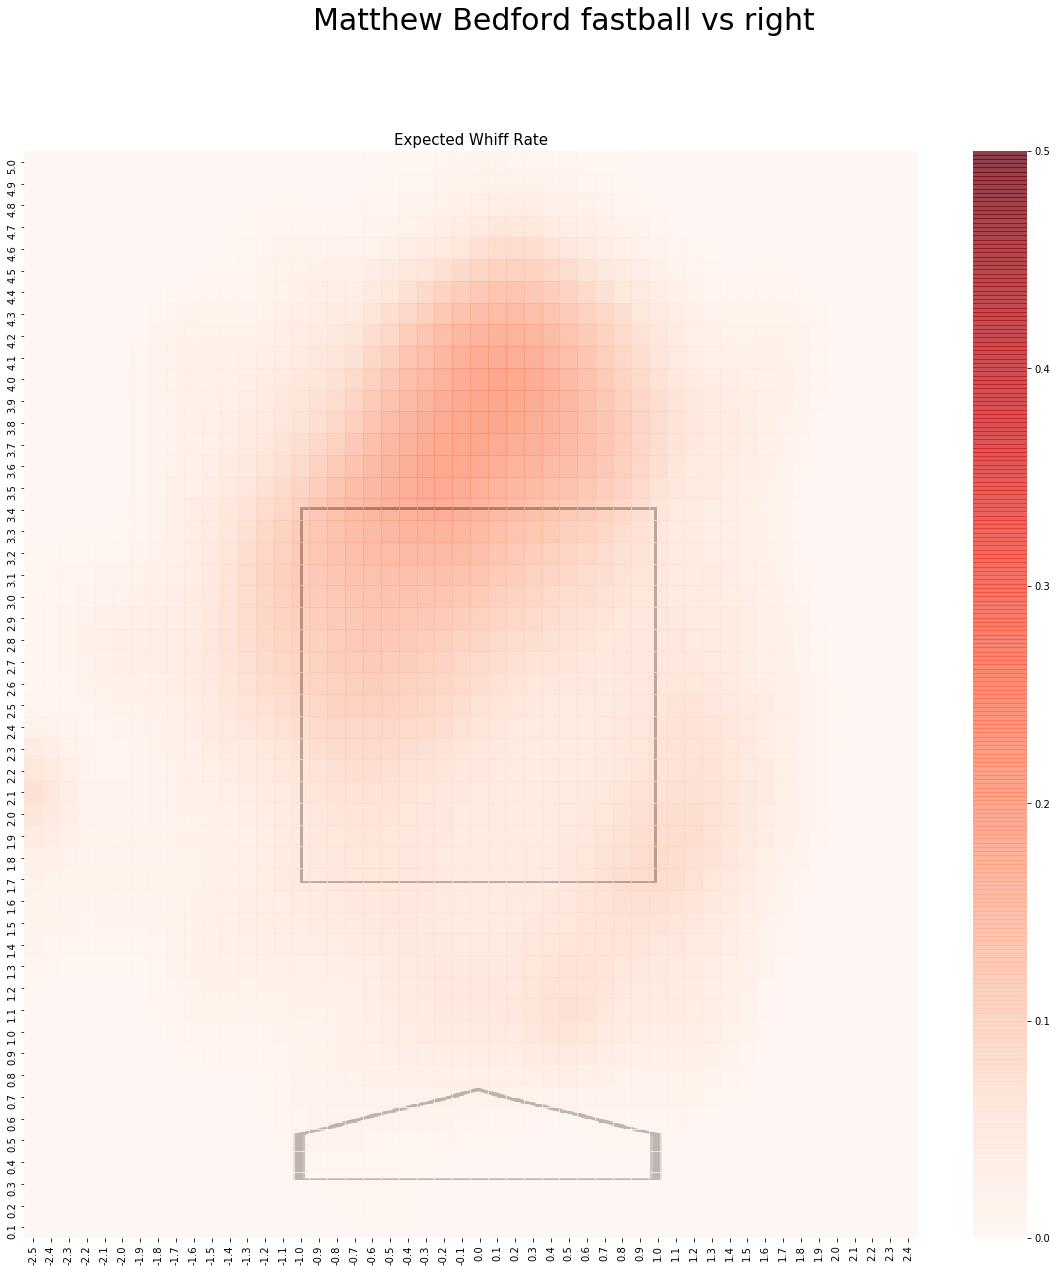

In [ ]:
n = 1
strike_zone = plt.imread('homeplate.png')
for pitcher in comps_dict.keys():
    first = pitcher.split(',')[1].strip()
    last = pitcher.split(',')[0].strip()
    for typ in comps_dict[pitcher].keys():
        for i in ['left', 'right']:
            for var in ['whiff%', 'Exit Speed', 'gb%']:
                
                key = i + '_' + var
                cur =  gaussian_filter(pd.DataFrame(comps_dict[pitcher][typ][key]), sigma = 2)

                x_axis = get_axis(-2.5, 2.5, step)
                y_axis = get_axis(5.0, 0.0, -step)

                title = first + ' ' + last + ' ' + typ +' vs ' + i

                fig = plt.figure(num = n, figsize = [20, 20])
                fig.suptitle(title, fontsize = 30)
                subtitle, colors, lower, upper, ext = get_title(var)
                plt.title(subtitle, fontsize = 15)


                left_hm = sns.heatmap(cur, cmap = colors, xticklabels = x_axis, 
                               yticklabels = y_axis, alpha = .75, zorder = 2, linewidths = 0.0,
                                vmin = lower, vmax = upper)
                               
                left_ext = (left_hm.get_xlim()[1]/2+0.5) - 11
                right_ext = (left_hm.get_xlim()[1]/2+0.5) + 11
                left_hm.imshow(strike_zone, zorder = 1, extent = (left_ext, right_ext) + (47.5, -2.5), 
                                   aspect = left_hm.get_aspect())
                path = last.lower() + '_' + typ + '_' + ext + '_vs' + i + '.png'
                fig.savefig(path)
                n += 1